In [1]:
import sys
sys.path.append('..')
from src.kitti import *
import numpy as np
import cv2
import json
import glob
from src.boundingbox import format_yolo_output
from src.trajectory import Trajectory
from src.sequence import load_keyframes

%matplotlib inline

### Analyzing KITTI sequence 00 image_2

In [2]:
LEFTDIR = '/data/urbinn/datasets/kitti/sequences/00/image_0'
RIGHTDIR = '/data/urbinn/datasets/kitti/sequences/00/image_1'

yolo_data = format_yolo_output("/data/urbinn/darknet/output/seq00_image02/objects.json")
                
frames = []
for filename in sorted(glob.glob(LEFTDIR + '/*')): 
    image_name = filename.split('/')[-1]
    frame = None
    
    if not image_name in yolo_data:
        print("frame {} has no yolo data available".format(image_name))
        frame = Frame(filename, RIGHTDIR)
    else:
        frame = Frame(filename, RIGHTDIR, yolo_data[image_name])
        
    frames.append(frame)

frame 004540.png has no yolo data available


Note: For some reason frame 004540 has no objects detected. This might be possible but requires further investigation.

#### Setting up a sequence

In [3]:
seq = Sequence()
for f in ProgressBar()(frames[:5]):
    seq.add_keyframe(f)

100% (5 of 5) |###########################| Elapsed Time: 0:00:06 Time: 0:00:06


In [4]:
DIMENSION = 400

poses = [kf.get_pose() for kf in seq.keyframes]

#### Evaluating trajectory plot

In [5]:
def load(file):
    keyframeids, frameids, poses = load_keyframes(file)
    return keyframeids, frameids, poses.reshape(poses.shape[0], 4, 4)

sequence = 0
folder = '/home/jeroen/notebooks/urb/resultspose'
keyframeids, frameids, poses_test = load(folder + '/keyframes_%02d_all_17_1.6_1.6.npy'%(sequence))

#### Update found observations with classifications

In [6]:
points_per_frame = []
for kf in seq.keyframes:
    kf.update_observations_per_classification()
    kf.filter_no_classification()
    obs = kf.get_observations()
    
    points_per_frame.append(obs)

#### Visualize observations with classifications per frame

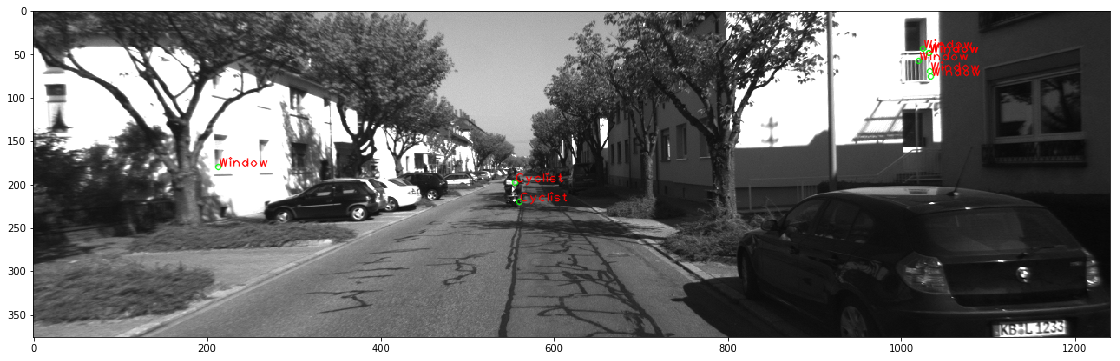

In [7]:
show(draw_observations_classification(points_per_frame[4]))

## Semantic Map

#### Plot trajectory with observations

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


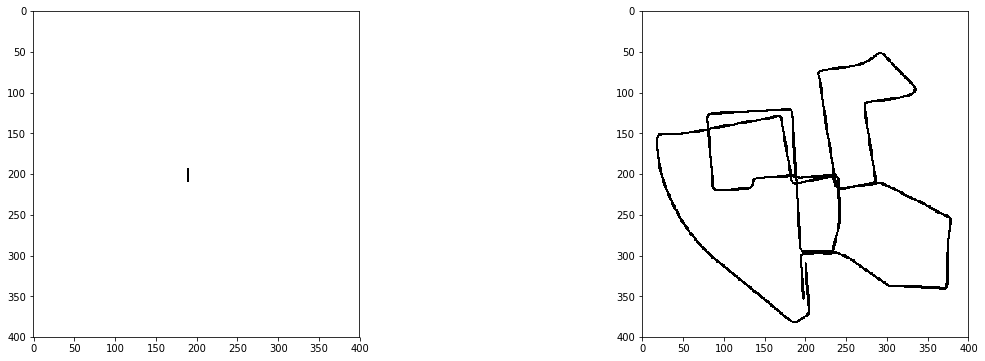

In [8]:
flatten = lambda l: [item for sublist in l for item in sublist]
trajectory = Trajectory(poses, (400, 400), [])
trajectory2 = Trajectory(poses_test, (400, 400), [])

show2(trajectory.draw(True, False), trajectory2.draw(True, False))
#trajectory._poses[:10]

#### Analyze found classes for setting up a legend

In [9]:
classifications = []
for obs in flatten(points_per_frame):
    if obs.classification not in classifications:
        classifications.append(obs.classification)

classifications

['Window', 'Cyclist']